In [5]:
import cv2
import time
import numpy as np
import dv_processing as dv
import dv_toolkit as kit
from datetime import timedelta

import matplotlib.pyplot as plt

from scipy.spatial import cKDTree
from numpy.lib.recfunctions import structured_to_unstructured

In [6]:
# Initialize reader
reader = kit.io.MonoCameraReader("./data/DvFire/aedat/s04_v06_c002.aedat4")

# Get offline MonoCameraData
data = reader.loadData()

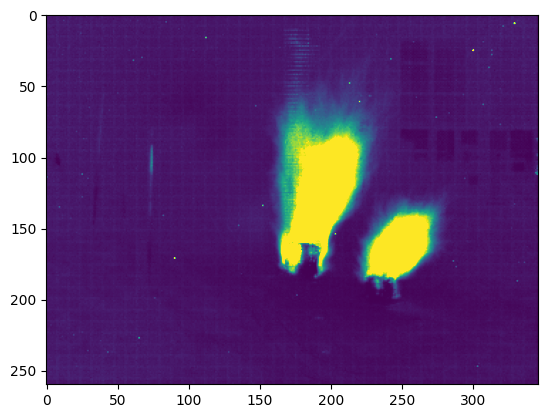

In [9]:
accumulator = dv.Accumulator(reader.getResolution("events"))
# Apply configuration, these values can be modified to taste
accumulator.setMinPotential(0)
accumulator.setMaxPotential(np.inf)
accumulator.setEventContribution(1.0)
accumulator.setIgnorePolarity(True)
accumulator.setDecayFunction(dv.Accumulator.Decay.NONE)

accumulator.accept(data["events"].toEventStore())
count = accumulator.getPotentialSurface()

plt.imshow(count, vmin=0, vmax=1000)
plt.show()

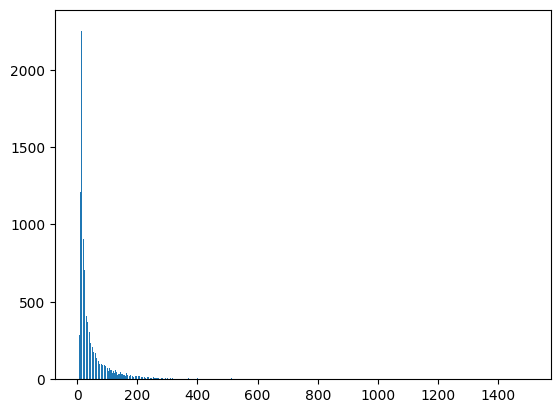

In [8]:
# Do statistics
events = np.rec.array(data.events().numpy())
points = np.c_[events.x, events.y]

stat = np.full((len(data.events()),), np.nan)

tree = cKDTree(points)
for i, evt in enumerate(data.events()):
    if (evt.timestamp() - events.timestamp[0]) > 50000:
        break

    indices = np.array(tree.query_ball_point((evt.x(), evt.y()), r=0, return_sorted=True))

    # get time difference greater than 0
    ts_diff = events[indices].timestamp - evt.timestamp()
    indices = indices[ts_diff > 0]
    ts_diff = ts_diff[ts_diff > 0]

    if ts_diff.size == 0: 
        continue
    
    stat[i] = ts_diff[0]

    # ind = (ts_diff[0]/100).astype(np.int_)
    # if ind >= 10000:
    #     continue

    # stat[ind] += 1

stat = np.array(stat) / 100
hist, bins = np.histogram(stat, bins=1500, range=(0, 1500))
# print(hist)
# print(bins)
plt.cla()
plt.bar(bins[1:], hist)
plt.show()

# plt.bar(range(len(stat)), stat)
# plt.show()